[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/porterjenkins/byu-cs474/blob/master/lab11_rl.ipynb)

# Deep Reinforcement Learning

## Objective

- Build Deep RL algorithms on the Cart Pole Problem
- Analyze the affects of various hyperparameters (like $\epsilon$ in the $\epsilon$-freedy algorithm).

### Cartpole

Cartpole is a simple environment to get your agent up and running. It has a continuous state space of 4 dimensions and a discrete action space of 2. The agent is given a reward of 1 for each timestep it remains standing. The agent should be able to reach close to 200 cumulative reward for an episode after a minute or two of training.

# Starter Code

## Init

In [ ]:
! pip3 install gymnasium
! pip3 install torch
! pip install pygame
! pip install moviepy==1.0.3
! pip install imageio_ffmpeg
! pip install pyvirtualdisplay
! apt-get install -y xvfb python3-opengl ffmpeg

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
python3-opengl is already the newest version (3.1.5+dfsg-1).
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.12).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [ ]:
from itertools import chain
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from gymnasium import logger as gymlogger
from gymnasium.wrappers import RecordVideo
from IPython import display
from numpy.typing import NDArray
from typing import Dict, Tuple
gymlogger.min_level = 40 # Error only

import gymnasium as gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
import numpy as np
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

# if GPU is to be used; MPS is for MAC
device = torch.device(
    "cuda:0" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)


In [ ]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400,900))
display.start()

In [ ]:
def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else:
    print("Could not find video")

def wrap_env(env):
  env = RecordVideo(env, './video')
  return env

## DQN

Deep Q-Network (https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf) is a Q-learning algorithm that learns values for state-action pairs.

Actions are sampled according to an $\epsilon-greedy$ policy to help with exploration of the state space. Every time an action is sampled, the agent chooses a random action with $\epsilon$ probability. Otherwise, the agent selects the action with the highest Q-value for a state. $\epsilon$ decays over time according to $\epsilon \gets \epsilon * epsilon\_decay$.

Tuples of state, action, reward, next_state, and terminal $(s,a,r,s',d)$ are collected during training. Every $learn\_frequency$ steps $sample\_size$ tuples are sampled and made into 5 tensors tensors of states, actions, rewarads, next_states, and terminals.

The loss for a batch of size N is given below.

$Loss=\frac{1}{N}\sum \bigg(Q(s,a) - (r + \gamma \underset{a'\sim A}{max} \hat{Q}(s',a')(1-d))\bigg)^2 $

Loss is calculated and used to update the Q-Network. The target network $\hat{Q}$ begins as a copy of the Q network but is not updated by the optimizer. Every $target\_update$ steps, the target network is updated with the parameters of the Q-Network. This process is a type of bootstrapping.




In [ ]:
from os import stat
def get_action_dqn(network, state, epsilon):
  """Select action according to e-greedy policy and decay epsilon

    Args:
        network (QNetwork): Q-Network
        state (np-array): current state, size (state_size)
        epsilon (float): probability of choosing a random action

    Returns:
        action (int): chosen action [0, action_size)
        epsilon (float): decayed epsilon
  """
  if random.random() < epsilon:  # With p=epsilon, take a random action
      action = random.randint(0, 1)
      return action
  else:  # With p=1-epsilon, take the action with the largest q-value
      state = torch.from_numpy(state).float().unsqueeze(0).to(device)
      q_values = network(state)
      action = torch.argmax(q_values).item()
      return action


def prepare_batch(memory, batch_size):
  """Randomly sample batch from memory
     Prepare cuda tensors

    Args:
        memory (list): state, action, next_state, reward, done tuples
        batch_size (int): amount of memory to sample into a batch

    Returns:
        state (tensor): float cuda tensor of size (batch_size x state_size)
        action (tensor): long tensor of size (batch_size)
        next_state (tensor): float cuda tensor of size (batch_size x state_size)
        reward (tensor): float cuda tensor of size (batch_size)
        done (tensor): float cuda tensor of size (batch_size)
  """
  batch = random.sample(memory, batch_size)  # Randomly sample batch from memory
  state, action, next_state, reward, done = zip(*batch)  # Unpack batch
  # Convert to tensors of correct types and return
  state = torch.from_numpy(np.array(state)).float().to(device)
  action = torch.from_numpy(np.array(action)).long().to(device)
  next_state = torch.from_numpy(np.array(next_state)).float().to(device)
  reward = torch.from_numpy(np.array(reward)).float().to(device)
  done = torch.from_numpy(np.array(done)).float().to(device)
  return state, action, next_state, reward, done


def learn_dqn(batch, optim, q_network, target_network, gamma, global_step, target_update):
  """Update Q-Network according to DQN Loss function
     Update Target Network every target_update global steps

    Args:
        batch (tuple): tuple of state, action, next_state, reward, and done tensors
        optim (Adam): Q-Network optimizer
        q_network (QNetwork): Q-Network
        target_network (QNetwork): Target Q-Network
        gamma (float): discount factor
        global_step (int): total steps taken in environment
        target_update (int): frequency of target network update
  """
  state, action, next_state, reward, done = batch

  q_values = q_network(state)  # Get the q values for the current state
  q_value = torch.gather(q_values, 1, action.unsqueeze(1)).squeeze(1)  # Get the q_value for the action

  next_q_values = target_network(next_state).detach()   # Get the q values for the next state
  next_q_value = torch.max(next_q_values, 1)[0]  # Get the largest q value of next state

  expected_q_value = reward + gamma*next_q_value*(1 - done)   # The target Q-value (via Bellman)
  loss = torch.mean(torch.pow(q_value - expected_q_value, 2))   # Calculate the loss

  # Gradient descent step
  optim.zero_grad()
  loss.backward()
  optim.step()

  # Update target network every target_update global steps
  if global_step % target_update == 0:
      target_network.load_state_dict(q_network.state_dict())

### Modules

In [ ]:
# Q-Value Network
class QNetwork(nn.Module):
  def __init__(self, state_size, action_size):
    super().__init__()
    hidden_size = 8

    self.net = nn.Sequential(nn.Linear(state_size, hidden_size),
                             nn.ReLU(),
                             nn.Linear(hidden_size, hidden_size),
                             nn.ReLU(),
                             nn.Linear(hidden_size, hidden_size),
                             nn.ReLU(),
                             nn.Linear(hidden_size, action_size))

  def forward(self, x):
    """Estimate q-values given state

      Args:
          state (tensor): current state, size (batch x state_size)

      Returns:
          q-values (tensor): estimated q-values, size (batch x action_size)
    """
    return self.net(x)

### Main

In [ ]:
def dqn_main(lr=1e-3, epochs=500, start_training=1000, gamma=0.99,
             batch_size=32, epsilon=1, epsilon_decay=lambda t, T: 0.9999**t,
             target_update=1000, learn_frequency=2, print_epsilon=False,
             num_steps=500):

  # Init environment
  state_size = 4
  action_size = 2
  env = gym.make('CartPole-v1', render_mode="rgb_array")

  # Init networks
  q_network = QNetwork(state_size, action_size).to(device)
  target_network = QNetwork(state_size, action_size).to(device)
  target_network.load_state_dict(q_network.state_dict())

  # Init optimizer
  optim = torch.optim.Adam(q_network.parameters(), lr=lr)
  # Init replay buffer
  memory = []

  # Begin main loop
  results_dqn = []
  global_step = 0
  loop = tqdm(total=epochs, position=0, leave=False)
  t = 0
  for epoch in range(epochs):
    last_epoch = (epoch+1 == epochs)
    # Record the last epoch, not the previous epochs
    if last_epoch:
      env = wrap_env(env)

    # Reset environment
    state, _ = env.reset()
    done = False
    cum_reward = 0  # Track cumulative reward per episode

    # Begin episode
    while not done and cum_reward < num_steps:  # End after 500 steps
      # Select e-greedy action
      epsilon = epsilon_decay(t)
      if print_epsilon: print(epsilon)
      t += 1
      action = get_action_dqn(q_network, state, epsilon)

      # Take step
      next_state, reward, terminated, truncated, _ = env.step(action)
      done = terminated or truncated
      # env.render()

      # Store step in replay buffer
      memory.append((state, action, next_state, reward, done))

      cum_reward += reward
      global_step += 1  # Increment total steps
      state = next_state  # Set current state

      # If time to train
      if global_step > start_training and global_step % learn_frequency == 0:

        # Sample batch
        batch = prepare_batch(memory, batch_size)

        # Train
        learn_dqn(batch, optim, q_network, target_network, gamma, global_step, target_update)
    env.close()
    # Print results at end of episode
    results_dqn.append(cum_reward)
    loop.update(1)
    loop.set_description('Episodes: {} Reward: {}'.format(epoch, cum_reward))

  return results_dqn

#show_video()

In [ ]:
results_dqn = []
decay_factors = [1, 0.99999, 0.9999, 0.999, 0.99, 0.9, 0.5, 0.1, 0]

for decay in decay_factors:
  print("decay factor:", decay)
  def exponential_decay(t): return decay**t
  result = dqn_main(epsilon_decay=exponential_decay)
  results_dqn.append(result)
  print("reward", max(result))
  print()

decay factor: 1


reward 70.0

decay factor: 0.99999


reward 102.0

decay factor: 0.9999


reward 500.0

decay factor: 0.999


reward 136.0

decay factor: 0.99


reward 33.0

decay factor: 0.9


reward 11.0

decay factor: 0.5


reward 11.0

decay factor: 0.1


reward 11.0

decay factor: 0


reward 11.0



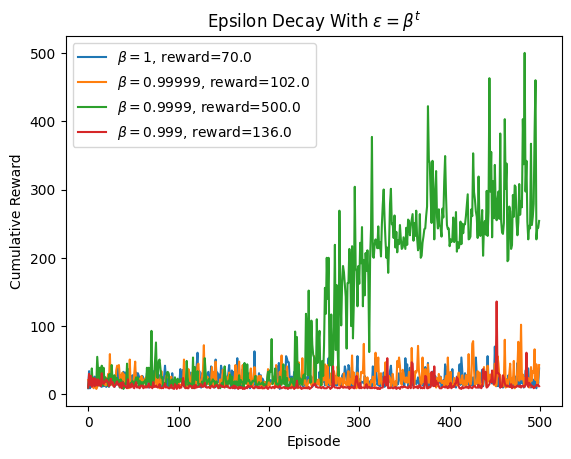

[70.0, 102.0, 500.0, 136.0]


In [ ]:
max_rewards = []
for i in range(len(results_dqn)):
  if i in [4, 5, 6, 7, 8]: continue
  plt.plot(results_dqn[i], label=fr"$\beta={decay_factors[i]}$, reward={max(results_dqn[i])}")
  max_rewards.append(max(results_dqn[i]))

plt.title(r"Epsilon Decay With $\epsilon=\beta^t$")
plt.xlabel("Episode")
plt.ylabel("Cumulative Reward")
plt.legend()
plt.show()

print(max_rewards)

In [ ]:
results_linear_decay = []

T = 500*50   # May need to play with this number
def linear_decay(epsilon_min, epsilon_max):
  def decay(t):
    return max([epsilon_min + (epsilon_max - epsilon_min) * (1 - t/T), 0])
  return decay

linear_decay_fun = linear_decay(0, 1)
result = dqn_main(epsilon_decay=linear_decay_fun, print_epsilon=False)
results_linear_decay.append(result)


#Calculate averages with window size 20
window_size = 20
moving_avg = np.convolve(results_linear_decay[0], np.ones(window_size)/window_size, mode='valid')


plt.plot(results_linear_decay[0])
plt.plot(range(window_size - 1, len(results_linear_decay[0])), moving_avg, label=f"Moving Average (window={window_size})", color="red", linewidth=2)
plt.title(rf"Epsilon Decay With $\epsilon=\text{{max}}\{{0,1-\frac{{t}}{{{T}}}\}}$")
plt.xlabel("Episode")
plt.ylabel("Cumulative Reward")
plt.legend()
plt.show()
print(max(results_linear_decay[0]))

In [ ]:
results_inverse_decay = []

k = 0.0003
def inverse_decay(k):
  def decay(t):
    return 1 / (1 + k*t)
  return decay

inverse_decay_fun = inverse_decay(k)
result = dqn_main(epsilon_decay=inverse_decay_fun, print_epsilon=False)
results_inverse_decay.append(result)


#Calculate averages with window size 20
window_size = 20
moving_avg = np.convolve(results_inverse_decay[0], np.ones(window_size)/window_size, mode='valid')


plt.plot(results_inverse_decay[0])
plt.plot(range(window_size - 1, len(results_inverse_decay[0])), moving_avg, label=f"Moving Average (window={window_size})", color="red", linewidth=2)
plt.title(rf"Epsilon Decay With $\epsilon=\frac{{1}}{{1+{k}t}}$")
plt.xlabel("Episode")
plt.ylabel("Cumulative Reward")
plt.legend()
plt.show()
print(max(results_inverse_decay[0]))

In [ ]:
results_log_decay = []

k = 0.10
def log_decay(k):
  def decay(t):
    return max(0, 1-k*np.log(t+1))
  return decay

log_decay_fun = log_decay(k)
result = dqn_main(epsilon_decay=log_decay_fun, print_epsilon=False)
results_log_decay.append(result)

#Calculate averages with window size 20
window_size = 20
moving_avg = np.convolve(results_log_decay[0], np.ones(window_size)/window_size, mode='valid')


plt.plot(results_log_decay[0])
plt.plot(range(window_size - 1, len(results_log_decay[0])), moving_avg, label=f"Moving Average (window={window_size})", color="red", linewidth=2)
plt.title(rf"Epsilon Decay With $\epsilon=\text{{max}}\{{0,1-{k}\log(t+1)\}}$")
plt.xlabel("Episode")
plt.ylabel("Cumulative Reward")
plt.legend()
plt.show()
print(max(results_log_decay[0]))

In [ ]:
results_sin_decay = []

beta = 0.9999
k = 0.5
def sin_decay(beta, k):
  def decay(t): return (beta**t)*np.abs(np.sin(k*t))
  return decay

sin_decay_fun = sin_decay(beta, k)
result = dqn_main(epsilon_decay=sin_decay_fun, print_epsilon=False)
results_sin_decay.append(result)

#Calculate averages with window size 20
window_size = 20
moving_avg = np.convolve(results_sin_decay[0], np.ones(window_size)/window_size, mode='valid')


plt.plot(results_sin_decay[0], color="blue")
plt.plot(range(window_size - 1, len(results_sin_decay[0])), moving_avg, label=f"Moving Average (window={window_size})", color="red", linewidth=2)
plt.title(rf"Epsilon Decay With $\epsilon={{{beta}}}^t|\sin({k}t)|$")
plt.xlabel("Episode")
plt.ylabel("Cumulative Reward")
plt.legend()
plt.show()
print(max(results_sin_decay[0]))

In [ ]:
results_sin_decay = []

EPS_START = 0.9999
EPS_END = 0.0001
T = 20000

def sin_decay(EPS_START, EPS_END, T):
  def decay(t): return EPS_END + (EPS_START - EPS_END) * (1 + np.sin(2*np.pi* t / T)) / 2
  return decay

sin_decay_fun = sin_decay(EPS_START, EPS_END, T)
result = dqn_main(epsilon_decay=sin_decay_fun, print_epsilon=False)
results_sin_decay.append(result)


window_size = 20
moving_avg = np.convolve(results_sin_decay[0], np.ones(window_size)/window_size, mode='valid')

# Plot the data and moving average
plt.figure(figsize=(10, 6))
plt.plot(results_sin_decay[0], color="blue", alpha=0.7)
plt.plot(range(window_size - 1, len(results_sin_decay[0])), moving_avg, label=f"Moving Average (window={window_size})", color="red", linewidth=2)
plt.title(rf"Epsilon Decay With $\epsilon={EPS_END} + {EPS_START - EPS_END}(1 + \sin(2pi*t/{T})/2)$")
plt.xlabel("Episodes")
plt.ylabel("Cumulative Reward")
plt.legend()
plt.grid(True)

# Customize the pl
plt.show()

In [ ]:
results_adapt_decay = []

EPS_START = 0.9999
EPS_END = 0.0001
TARGET_AVG = 65
T = 0.00005
epsilon = EPS_START


def adapt_decay(EPS_START, EPS_END, TARGET_AVG, results_adapt_decay, T):
  def decay(t):
    global epsilon
    end = len(results_adapt_decay)
    if end <= 20:
      running_reward = np.mean(results_adapt_decay)
    else:
      running_reward = np.mean(results_adapt_decay[end-21, end-1])
    if running_reward < TARGET_AVG:
      epsilon = min(epsilon + T, EPS_START)
    else:
      epsilon = max(epsilon - T, EPS_END)
    return epsilon
  return decay

adapt_decay_fun = adapt_decay(EPS_START, EPS_END, TARGET_AVG, results_adapt_decay, T)
result = dqn_main(epsilon_decay=adapt_decay_fun, print_epsilon=False)
results_adapt_decay.append(result)


window_size = 20
moving_avg = np.convolve(results_adapt_decay[0], np.ones(window_size)/window_size, mode='valid')

# Plot the data and moving average
plt.figure(figsize=(10, 6))
plt.plot(results_adapt_decay[0], color="blue", alpha=0.7)
plt.plot(range(window_size - 1, len(results_adapt_decay[0])), moving_avg, label=f"Moving Average (window={window_size})", color="red", linewidth=2)
plt.title(rf"Epsilon Decay With Adaptive Decay")
plt.xlabel("Episodes")
plt.ylabel("Cumulative Reward")
plt.legend()
plt.grid(True)

# Customize the pl
plt.show()

# Prioritized Experience Replay (PER)

In [ ]:
from collections import namedtuple

# Define a named tuple for the experience
Experience = namedtuple('Experience', ['state', 'action', 'next_state', 'reward', 'done', 'priority'])

class PrioritizedReplayBuffer:
    def __init__(self, capacity, alpha):
        self.capacity = capacity
        self.alpha = alpha
        self.buffer = []
        self.priorities = np.zeros((capacity,), dtype=np.float32)
        self.position = 0

    def add(self, state, action, next_state, reward, done):
        #give max priority to the most recently added state
        max_priority = self.priorities.max() if self.buffer else 1.0
        experience = Experience(state, action, next_state, reward, done, max_priority)
        if len(self.buffer) < self.capacity:
            self.buffer.append(experience)
        else:
            self.buffer[self.position] = experience #replace experience at position with new experience
        self.priorities[self.position] = max_priority #replace priority at position with max_priority
        self.position = (self.position + 1) % self.capacity #increment position

    def sample(self, batch_size, beta):
        if len(self.buffer) == self.capacity:
            priorities = self.priorities
        else:
            priorities = self.priorities[:self.position]
        #Turn priorities into probabilities
        probabilities = priorities ** self.alpha
        probabilities /= probabilities.sum()
        #randomly sample batch of experiences based on probabilities
        indices = np.random.choice(len(self.buffer), batch_size, p=probabilities)
        experiences = [self.buffer[idx] for idx in indices]
        #Weight each probability
        weights = (len(self.buffer) * probabilities[indices]) ** (-beta)
        weights /= weights.max()
        weights = torch.tensor(weights, dtype=torch.float32).to(device)

        states, actions, next_states, rewards, dones = zip(*[(e.state, e.action, e.next_state, e.reward, e.done) for e in experiences])
        return (
            (torch.tensor(states, dtype=torch.float32).to(device),
            torch.tensor(actions, dtype=torch.int64).to(device),
            torch.tensor(next_states, dtype=torch.float32).to(device),
            torch.tensor(rewards, dtype=torch.float32).to(device),
            torch.tensor(dones, dtype=torch.float32).to(device)),
            weights,
            indices
        )

    def update_priorities(self, indices, priorities):
        for idx, priority in zip(indices, priorities):
            self.priorities[idx] = priority

In [ ]:
def per_learn_dqn(batch, weights, indices, replay_buffer, optim, q_network, target_network, gamma, global_step, target_update):

  state, action, reward, next_state, done = batch

  q_values = q_network(state)  # Get the q values for the current state
  q_value = torch.gather(q_values, 1, action.unsqueeze(1)).squeeze(1)  # Get the q_value for the action

  next_q_values = target_network(next_state).detach()   # Get the q values for the next state
  next_q_value = torch.max(next_q_values, 1)[0]  # Get the largest q value of next state

  expected_q_value = reward + gamma*next_q_value*(1 - done)   # The target Q-value (via Bellman)
  td_error = torch.abs(expected_q_value - q_value)
  loss = torch.mean(torch.pow(td_error*weights, 2))   # Calculate the weighted loss

  # Gradient descent step
  optim.zero_grad()
  loss.backward()
  optim.step()

  # Update priorities in the replay buffer
  priorities = td_error.abs().detach().cpu().numpy() + 1e-5
  replay_buffer.update_priorities(indices, priorities)

  # Update target network every target_update global steps
  if global_step % target_update == 0:
      target_network.load_state_dict(q_network.state_dict())

In [ ]:
def per_dqn_main(lr=1e-3, epochs=500, start_training=1000, gamma=0.99,
             batch_size=32, epsilon=1, epsilon_decay=lambda t, T: 0.9999**t,
             target_update=1000, learn_frequency=2, print_epsilon=False,
             num_steps=500):

  # Init environment
  state_size = 4
  action_size = 2
  env = gym.make('CartPole-v1', render_mode="rgb_array")

  # Init networks
  q_network = QNetwork(state_size, action_size).to(device)
  target_network = QNetwork(state_size, action_size).to(device)
  target_network.load_state_dict(q_network.state_dict())

  # Init optimizer
  optim = torch.optim.Adam(q_network.parameters(), lr=lr)
  # Init replay buffer
  replay_buffer = PrioritizedReplayBuffer(capacity=100000, alpha=0.6)

  # Begin main loop
  results_dqn = []
  global_step = 0
  loop = tqdm(total=epochs, position=0, leave=False)
  t = 0
  for epoch in range(epochs):
    last_epoch = (epoch+1 == epochs)
    # Record the last epoch, not the previous epochs
    if last_epoch:
      env = wrap_env(env)

    # Reset environment
    state, _ = env.reset()
    done = False
    cum_reward = 0  # Track cumulative reward per episode

    # Begin episode
    while not done and cum_reward < num_steps:  # End after 500 steps
      # Select e-greedy action
      epsilon = epsilon_decay(t)
      if print_epsilon: print(epsilon)
      t += 1
      action = get_action_dqn(q_network, state, epsilon)

      # Take step
      next_state, reward, terminated, truncated, _ = env.step(action)
      done = terminated or truncated
      # env.render()

      # Store step in replay buffer
      replay_buffer.add(state, action, reward, next_state, done)

      cum_reward += reward
      global_step += 1  # Increment total steps
      state = next_state  # Set current state

      # If time to train
      if global_step > start_training and global_step % learn_frequency == 0:

        # Sample batch
        beta = 0.4  # Initial beta value
        beta_increment = 1e-4  # Increment per step
        batch, weights, indices = replay_buffer.sample(batch_size, beta)
        #train
        per_learn_dqn(batch, weights, indices, replay_buffer, optim, q_network, target_network, gamma, global_step, target_update)

        beta = min(1.0, beta + beta_increment)  # Gradually increase beta

    env.close()
    # Print results at end of episode
    results_dqn.append(cum_reward)
    loop.update(1)
    loop.set_description('Episodes: {} Reward: {}'.format(epoch, cum_reward))

  return results_dqn

## Run Prioritized Experience Replay Model with Various Epsilon Greedy Policies

Episodes: 43 Reward: 17.0:   9%|▉         | 44/500 [00:00<00:01, 237.47it/s]<ipython-input-17-9b912f678f34>:43: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  (torch.tensor(states, dtype=torch.float32).to(device),


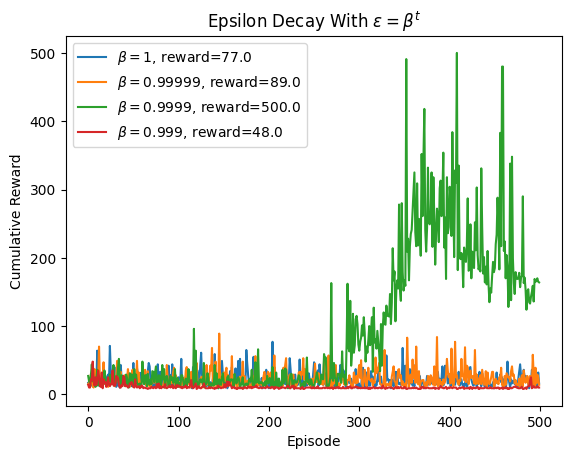

[77.0, 89.0, 500.0, 48.0]


In [ ]:
#Exponential Epsilon Decays

results_dqn = []
decay_factors = [1, 0.99999, 0.9999, 0.999, 0.99, 0.9, 0.5, 0.1, 0]

for decay in decay_factors:
  def exponential_decay(t): return decay**t
  result = per_dqn_main(epsilon_decay=exponential_decay)
  results_dqn.append(result)

max_rewards = []
for i in range(len(results_dqn)):
  if i in [4, 5, 6, 7, 8]: continue
  plt.plot(results_dqn[i], label=fr"$\beta={decay_factors[i]}$, reward={max(results_dqn[i])}")
  max_rewards.append(max(results_dqn[i]))

plt.title(r"Epsilon Decay With $\epsilon=\beta^t$")
plt.xlabel("Episode")
plt.ylabel("Cumulative Reward")
plt.legend()
plt.show()

print(max_rewards)

In [ ]:
results_linear_decay = []

T = 500*50   # May need to play with this number
def linear_decay(epsilon_min, epsilon_max):
  def decay(t):
    return max([epsilon_min + (epsilon_max - epsilon_min) * (1 - t/T), 0])
  return decay

linear_decay_fun = linear_decay(0, 1)
result = per_dqn_main(epsilon_decay=linear_decay_fun, print_epsilon=False)
results_linear_decay.append(result)


#Calculate averages with window size 20
window_size = 20
moving_avg = np.convolve(results_linear_decay[0], np.ones(window_size)/window_size, mode='valid')


plt.plot(results_linear_decay[0])
plt.plot(range(window_size - 1, len(results_linear_decay[0])), moving_avg, label=f"Moving Average (window={window_size})", color="red", linewidth=2)
plt.title(rf"Epsilon Decay With $\epsilon=\text{{max}}\{{0,1-\frac{{t}}{{{T}}}\}}$")
plt.xlabel("Episode")
plt.ylabel("Cumulative Reward")
plt.legend()
plt.show()
print(max(results_linear_decay[0]))

In [ ]:
results_inverse_decay = []

k = 0.0003
def inverse_decay(k):
  def decay(t):
    return 1 / (1 + k*t)
  return decay

inverse_decay_fun = inverse_decay(k)
result = per_dqn_main(epsilon_decay=inverse_decay_fun, print_epsilon=False)
results_inverse_decay.append(result)


#Calculate averages with window size 20
window_size = 20
moving_avg = np.convolve(results_inverse_decay[0], np.ones(window_size)/window_size, mode='valid')


plt.plot(results_inverse_decay[0])
plt.plot(range(window_size - 1, len(results_inverse_decay[0])), moving_avg, label=f"Moving Average (window={window_size})", color="red", linewidth=2)
plt.title(rf"Epsilon Decay With $\epsilon=\frac{{1}}{{1+{k}t}}$")
plt.xlabel("Episode")
plt.ylabel("Cumulative Reward")
plt.legend()
plt.show()
print(max(results_inverse_decay[0]))

In [ ]:
results_log_decay = []

k = 0.10
def log_decay(k):
  def decay(t):
    return max(0, 1-k*np.log(t+1))
  return decay

log_decay_fun = log_decay(k)
result = per_dqn_main(epsilon_decay=log_decay_fun, print_epsilon=False)
results_log_decay.append(result)

#Calculate averages with window size 20
window_size = 20
moving_avg = np.convolve(results_log_decay[0], np.ones(window_size)/window_size, mode='valid')


plt.plot(results_log_decay[0])
plt.plot(range(window_size - 1, len(results_log_decay[0])), moving_avg, label=f"Moving Average (window={window_size})", color="red", linewidth=2)
plt.title(rf"Epsilon Decay With $\epsilon=\text{{max}}\{{0,1-{k}\log(t+1)\}}$")
plt.xlabel("Episode")
plt.ylabel("Cumulative Reward")
plt.legend()
plt.show()
print(max(results_log_decay[0]))

In [ ]:
results_sin_decay = []

beta = 0.9999
k = 0.5
def sin_decay(beta, k):
  def decay(t): return (beta**t)*np.abs(np.sin(k*t))
  return decay

sin_decay_fun = sin_decay(beta, k)
result = per_dqn_main(epsilon_decay=sin_decay_fun, print_epsilon=False)
results_sin_decay.append(result)

#Calculate averages with window size 20
window_size = 20
moving_avg = np.convolve(results_sin_decay[0], np.ones(window_size)/window_size, mode='valid')


plt.plot(results_sin_decay[0], color="blue")
plt.plot(range(window_size - 1, len(results_sin_decay[0])), moving_avg, label=f"Moving Average (window={window_size})", color="red", linewidth=2)
plt.title(rf"Epsilon Decay With $\epsilon={{{beta}}}^t|\sin({k}t)|$")
plt.xlabel("Episode")
plt.ylabel("Cumulative Reward")
plt.legend()
plt.show()
print(max(results_sin_decay[0]))

Q-learning

In [ ]:
def epsilon_decay(episode, N, epsilon_start=1.0, epsilon_end=0.9512270462715808):
    """ Decay epsilon value over time according to an exponential decay.
    Parameters:
        episode (int): current episode number (starting from 1)
        N (int): total number of episodes
        epsilon_start (float): starting epsilon value
        epsilon_end (float): ending epsilon value
    Returns:
        epsilon (float): decayed epsilon value
    """


    return epsilon_start * (epsilon_end/epsilon_start)**(episode/N)

In [ ]:
def get_discrete_state(state):
    np_array_win_size = np.array([0.25, 0.25, 0.01, 0.1])
    discrete_state = state/np_array_win_size + np.array([15,10,1,10])
    return tuple(discrete_state.astype(int))

In [ ]:
def qlearning(env:str, alpha:float=1e-3, gamma:float=0.99, epsilon:float=0.35, N:int=70_000, decay:bool=False) -> Tuple[NDArray, Dict]:
    """ Use the Q-learning algorithm to find qvalues.
    Parameters:
        - env (str): environment name (Gymnasium environment)
        - alpha (float): learning rate
        - gamma (float): discount factor
        - epsilon (float): epsilon value for epsilon-greedy algo
        - N (int): number of episodes to train for
        - decay (bool): whether to decay epsilon according to epsilon_decay

    Returns:
        - q_table (ndarray nxm): the Q(s,a) approximation values
    """

    Observation = [50, 50, 90, 90]
    env = gym.make(env, render_mode="rgb_array")
    q_table=  np.zeros(shape=(Observation + [env.action_space.n]))
    cum_rewards = {} # Dict of cumulative reward per episode

    # Train for N episodes
    for i in range(1, N+1):

        # Get epsilon value
        if not decay:
            epsilon = epsilon
        else:
            epsilon = epsilon_decay(i, N)

        # Reset env and get initial state; Initialize penalties, reward, done
        thing, _ = env.reset()
        curr_state = get_discrete_state(thing)
        episode_reward = 0
        step_reward = 0
        done = False


        # Keep going until the terminal state is reached
        while not done:

        # Employ epsilon-greedy algo
            if random.uniform(0,1) < epsilon:                  # Explore
                curr_action = env.action_space.sample()
            else:                                              # Exploit
                curr_action = (q_table[curr_state]).argmax()

            # Take action and get new state and reward
            next_state, step_reward, done, truncated, info = env.step(curr_action)
            next_state = get_discrete_state(next_state)

            # Calculate new qvalue
            old_value = q_table[curr_state + (curr_action,)]
            next_max = (q_table[next_state]).max()
            new_value = (1-alpha)*old_value + alpha*(step_reward + gamma*next_max)
            q_table[curr_state + (curr_action,)] = new_value

            # Get next observation
            curr_state = next_state

            #Update episode reward
            episode_reward += step_reward

        cum_rewards[i] = episode_reward
        if i % 10 == 0:
            display.clear_output(wait=True)
            print("Training model...")
            print(f"Episode: {i}")

    env.close()
    print("Training finished.")

    return q_table, cum_rewards

In [ ]:
def plotter(dict:Dict, save:bool=False, img_name:str='./qlearn_rewards.pdf') -> None:
    ax = plt.subplot(111)
    rewards = np.array(list(dict.values()))
    episodes = np.array(list(dict.keys()))
    avgs = np.cumsum(rewards)/episodes

    ax.plot(episodes, rewards, color='blue', label='Total Reward of Episode')
    ax.plot(episodes, avgs, color='red', label='Average Cumulative Reward of N Episodes')
    ax.set_xlabel("Episode")
    ax.set_ylabel("Reward")
    ax.set_title("Reward as a function of Episode")
    ax.legend()

    if save:
        plt.savefig(img_name, format='pdf')
    plt.show()

    return avgs

In [ ]:
Q, rewards = qlearning(env='CartPole-v1', N=500, epsilon=0.45, decay=True)

In [ ]:
avgs = plotter(rewards, save=False, img_name='./qlearn_rewards.pdf')

DQN witn no Experience Replay

In [ ]:
def learn_dqn_single(state, action, next_state, reward, done, optim, q_network, target_network, gamma, global_step, target_update):
    """Update Q-Network using a single transition."""
    state = torch.from_numpy(state).float().unsqueeze(0).to(device)
    next_state = torch.from_numpy(next_state).float().unsqueeze(0).to(device)
    action = torch.tensor([[action]]).to(device)
    reward = torch.tensor([reward]).to(device)
    done = torch.tensor([done]).float().to(device)

    # Compute Q(s, a)
    q_values = q_network(state)
    q_value = q_values.gather(1, action).squeeze(1)

    # Compute max_a' Q'(s', a') for the target
    next_q_values = target_network(next_state).detach()
    next_q_value = torch.max(next_q_values, 1)[0]

    # Bellman equation target
    expected_q_value = reward + gamma * next_q_value * (1 - done)

    # Loss and backpropagation
    loss = torch.mean((q_value - expected_q_value) ** 2)
    optim.zero_grad()
    loss.backward()
    optim.step()

    # Update target network
    if global_step % target_update == 0:
        target_network.load_state_dict(q_network.state_dict())

In [ ]:
def dqn_main_no_replay(lr=1e-3, epochs=500, gamma=0.99, epsilon=1, epsilon_decay=lambda t: epsilon_decay(t+1),
                       target_update=1000, num_steps=500):
    """DQN without experience replay."""
    # Init environment
    state_size = 4
    action_size = 2
    env = gym.make('CartPole-v1', render_mode="rgb_array")

    # Init networks
    q_network = QNetwork(state_size, action_size).to(device)
    target_network = QNetwork(state_size, action_size).to(device)
    target_network.load_state_dict(q_network.state_dict())

    # Init optimizer
    optim = torch.optim.Adam(q_network.parameters(), lr=lr)

    # Begin main loop
    results_dqn = []
    global_step = 0
    loop = tqdm(total=epochs, position=0, leave=False)
    t = 0
    for epoch in range(epochs):
        last_epoch = (epoch + 1 == epochs)
        if last_epoch:
            env = wrap_env(env)

        state, _ = env.reset()
        done = False
        cum_reward = 0

        while not done and cum_reward < num_steps:
            # Select e-greedy action
            epsilon = epsilon_decay(t)
            t += 1
            action = get_action_dqn(q_network, state, epsilon)

            # Take step
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            # Train using the current transition
            learn_dqn_single(state, action, next_state, reward, done, optim, q_network, target_network, gamma, global_step, target_update)

            cum_reward += reward
            global_step += 1
            state = next_state

        env.close()
        results_dqn.append(cum_reward)
        loop.update(1)
        loop.set_description('Episodes: {} Reward: {}'.format(epoch, cum_reward))

    return results_dqn

In [ ]:
results_dqn_no_replay = dqn_main_no_replay()
show_video()

In [ ]:
SAVE = True
ax = plt.subplot(111)
avgs = np.cumsum(np.array(results_dqn_no_replay))/np.arange(1,501)
ax.plot(list(range(1,501)), results_dqn_no_replay, color='blue', label='Cumulative Reward per Episode')
ax.plot(list(range(1,501)), avgs, color='red', label='Cumulative Episodic Reward Average')
ax.set_ylabel("Reward")
ax.set_xlabel("Episode")
ax.set_title("Reward per Episode")
ax.legend()

if SAVE:
    plt.savefig("./dqn_no_ep_exp_epsilon.pdf", format='pdf')

plt.show()